# Time Series Prediction with Long Short Term Merory Networks ($LSTM$)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Gathering Dependencies

_Importing Required Libraries_

In [27]:
pip install hampel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Loading Datasets

_El NINO_

In [29]:
data = pd.read_csv("/content/drive/MyDrive/new/datasets/elnino.csv")
training_set = data.iloc[:, 1]
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


## Preprocessing the Data

In [30]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[23.4 23.4 24.2] 24.4
[23.4 24.2 24.4] 25.1
[24.2 24.4 25.1] 25.8
[24.4 25.1 25.8] 25.9
[25.1 25.8 25.9] 26.1
[25.8 25.9 26.1] 26.1
[25.9 26.1 26.1] 26.7
[26.1 26.1 26.7] 26.1
[26.1 26.7 26.1] 26.1
[26.7 26.1 26.1] 25.7
[26.1 26.1 25.7] 25.6
[26.1 25.7 25.6] 25.1
[25.7 25.6 25.1] 25.3
[25.6 25.1 25.3] 25.1
[25.1 25.3 25.1] 24.6
[25.3 25.1 24.6] 24.2
[25.1 24.6 24.2] 24.3
[24.6 24.2 24.3] 23.7
[24.2 24.3 23.7] 23.4
[24.3 23.7 23.4] 23.2
[23.7 23.4 23.2] 22.8
[23.4 23.2 22.8] 22.5
[23.2 22.8 22.5] 22.1
[22.8 22.5 22.1] 21.7
[22.5 22.1 21.7] 21.3
[22.1 21.7 21.3] 21.0
[21.7 21.3 21. ] 20.2
[21.3 21.  20.2] 20.6
[21.  20.2 20.6] 20.4
[20.2 20.6 20.4] 20.4
[20.6 20.4 20.4] 19.8
[20.4 20.4 19.8] 20.2
[20.4 19.8 20.2] 19.7
[19.8 20.2 19.7] 20.1
[20.2 19.7 20.1] 20.3
[19.7 20.1 20.3] 20.3
[20.1 20.3 20.3] 20.8
[20.3 20.3 20.8] 20.1
[20.3 20.8 20.1] 20.3
[20.8 20.1 20.3] 20.1
[20.1 20.3 20.1] 20.2
[20.3 20.1 20.2] 20.5
[20.1 20.2 20.5] 20.8
[20.2 20.5 20.8] 20.9
[20.5 20.8 20.9] 21.5
[20.8 20.9

## Train and Test Split

In [31]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1304, 1, 3) (1304,) (327, 1, 3) (327,)


## Model ($LSTM$)

In [32]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(3, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), verbose=1, shuffle=False)

# # fit model
# history = model.fit(X, y,epochs=50)

Epoch 1/500
21/21 [==============================] - 7s 63ms/step - loss: 505.1880 - val_loss: 463.9140
Epoch 2/500
21/21 [==============================] - 0s 17ms/step - loss: 374.1693 - val_loss: 299.2419
Epoch 3/500
21/21 [==============================] - 0s 15ms/step - loss: 239.4388 - val_loss: 207.6103
Epoch 4/500
21/21 [==============================] - 0s 17ms/step - loss: 177.8786 - val_loss: 169.2850
Epoch 5/500
21/21 [==============================] - 0s 15ms/step - loss: 148.7346 - val_loss: 144.4421
Epoch 6/500
21/21 [==============================] - 0s 17ms/step - loss: 126.8356 - val_loss: 124.5078
Epoch 7/500
21/21 [==============================] - 0s 15ms/step - loss: 109.0775 - val_loss: 107.6085
Epoch 8/500
21/21 [==============================] - 0s 16ms/step - loss: 94.3130 - val_loss: 93.0288
Epoch 9/500
21/21 [==============================] - 0s 16ms/step - loss: 80.8402 - val_loss: 80.3928
Epoch 10/500
21/21 [==============================] - 0s 17ms/step -

## Metrics ($LSTM$)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX, verbose=0)
rmse = np.sqrt(mean_squared_error(testY, yhat))
mae = np.sqrt(mean_absolute_error(testY, yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.497
Test MAE: 0.624


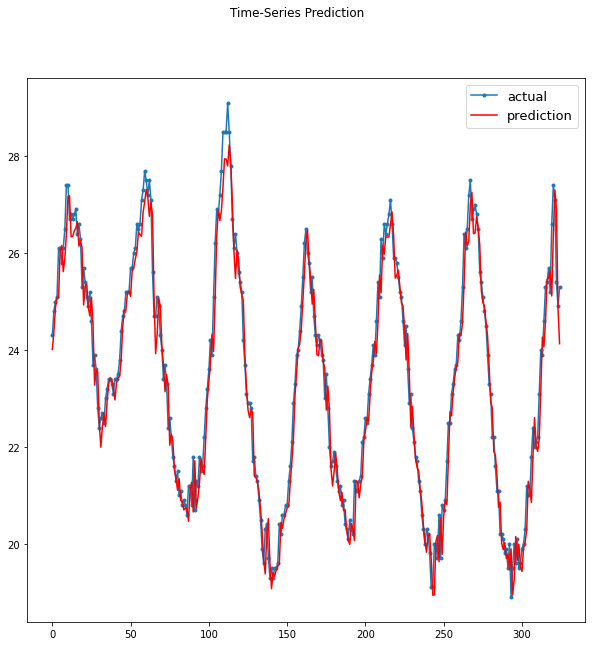

In [34]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
anurag=[x for x in range(325)]
plt.plot(anurag, testY[:3064], marker='.', label="actual")
plt.plot(anurag, yhat[:3064], 'r', label="prediction")
plt.suptitle('Bjørnøya Daily Downpour', fontsize=20)
plt.legend(fontsize=20)
plt.show()